# Imports

In [1]:
import numpy as np
import scipy
import os
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

import pickle
import seaborn as sns
from scipy.stats import poisson
from tqdm import tqdm
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different characteristic of the data impact our ability to decode position.
In particular:

A - Try to use different fraction of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

### A

In [3]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

# we compute histograms for each cell
spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

# code decoding
true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:]) > 0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   


100%|█████████████████████████████████████████████████████████████████████████████| 5231/5231 [00:22<00:00, 232.03it/s]


In [4]:
# compute the errors
mse = np.sqrt((true_x - x_decoded) ** 2)

@interact(percentage=(1, 100, 1))
def plot_hist(percentage):
    num_data = int(len(mse) * percentage / 100)
    data_to_plot = np.sort(mse)[:num_data]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data_to_plot)
    median_error = np.nanmedian(data_to_plot)
    plt.axvline(x=median_error, c='r')
    plt.title(f"Histogram with top {percentage}% of data. Median error = {median_error:.2f}")
    plt.show()


interactive(children=(IntSlider(value=50, description='percentage', min=1), Output()), _dom_classes=('widget-i…

We can see in the interactive plot above that the median error increases with in increase of data. From an error of 
0.01 for 1% of total data, 
0.42 for 12%
0.86 for 25%,
1.74 for 50%,
3.62 for 100%.
There is thus a simple linear relation between the two variables.

### B

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:36<00:00, 21.67s/it]


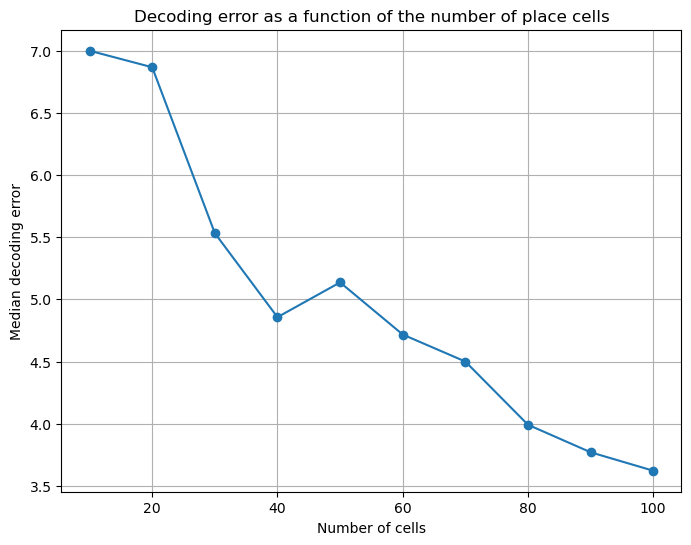

In [5]:
cell_numbers = np.arange(10, spikes_hist.shape[0] + 1, 10)
median_errors = []

for n_cells in tqdm(cell_numbers):
    # Select a random subset
    cell_indices = np.random.choice(spikes_hist.shape[0], n_cells, replace=False)
    firing_rate_maps_subset = firing_rate_maps[cell_indices]
    spikes_count_subset = spikes_count[:, cell_indices]

    # Decode the position
    x_decoded = np.zeros_like(true_x)
    for t_bin in range(len(decoding_times)):
        if sum(spikes_count_subset[t_bin, :]) > 0:
            posterior = np.empty(firing_rate_maps_subset.shape[1])

            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count_subset[t_bin, :], firing_rate_maps_subset[:, i] / fps) + pow(1, -15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    # Compute the error
    mse = np.sqrt((true_x - x_decoded) ** 2)
    median_error = np.nanmedian(mse)
    median_errors.append(median_error)

plt.figure(figsize=(8, 6))
plt.plot(cell_numbers, median_errors, 'o-')
plt.xlabel('Number of cells')
plt.ylabel('Median decoding error')
plt.title('Decoding error as a function of the number of place cells')
plt.grid(True)
plt.show()


We can see that the meadian decoding error decreases by about a factor three going from 10 to 100 place cells. It depends how do you define 'reliable', in other words, at what error value the threshold is between reliable and unreliable. However, if we look at the graph we see that after about 60-70 place cells the slope becomes significantly lower. Therefore an increase in place cells results in a low improvement in the median error. I'd thus argue that this is the range where you start to reliable decode. We don't really have enough data to conclude that there is asymptotic behavour from the plot. However the obvious (theoretical) minimal value for the median error is 0. The graph does show the error to slowly creep towards 0, so we could argue that there is symptotic behaviour.

### C

In [6]:
def gen_new_data(noise_firing_rate):
    # Parameters    
    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5
    n_cells = 100 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    # GENERATE TRAJECTORY
    n_runs = 10
    use_stops = False
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 10 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])

    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
             x = np.concatenate((x, run1, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    file_name = f'linear_track_data_fr{noise_firing_rate}.pickle'
    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps

    with open(f'G:\\My Drive\\Neurophysics Master\\2022\\NA\\population-methods-main\\02-bayes-decoding\\data\\{file_name}','wb') as f:
        pickle.dump(out_data,f)
        
    return

In [7]:
# No need to run this again.
"""
noise_firing_rate_list = [0.001, 0.01, 0.1, 0.2, 0.5, 1]
for noise_firing_rate in noise_firing_rate_list:
    gen_new_data(noise_firing_rate)
"""

'\nnoise_firing_rate_list = [0.001, 0.01, 0.1, 0.2, 0.5, 1]\nfor noise_firing_rate in noise_firing_rate_list:\n    gen_new_data(noise_firing_rate)\n'

In [8]:
def decode(data_name):
    # If you want to run this again you will have to change the path
    # I couldn't get it to work from the current directory unfortunately.
    full_path = 'G:\\My Drive\\Neurophysics Master\\2022\\NA\\population-methods-main\\02-bayes-decoding\\data\\' + data_name
    with open(full_path, 'rb') as handle:
        data = pickle.load(handle)
    
    x,t,spikes = data['x'],data['t'],data['spikes']
    track_length = data['track_length']
    fps = data['fps'] 
    n_cells = len(spikes)
    
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape
    
    # Decode
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    
    x_decoded = np.zeros_like(true_x)
    for t_bin in range(len(decoding_times)):
        if sum(spikes_count[t_bin, :]) > 0:
            posterior = np.empty(firing_rate_maps.shape[1])

            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin, :], firing_rate_maps[:, i] / fps) + pow(1, -15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    # Compute the error
    mse = np.sqrt((true_x - x_decoded) ** 2)
    median_error = np.nanmedian(mse)
    
    return median_error

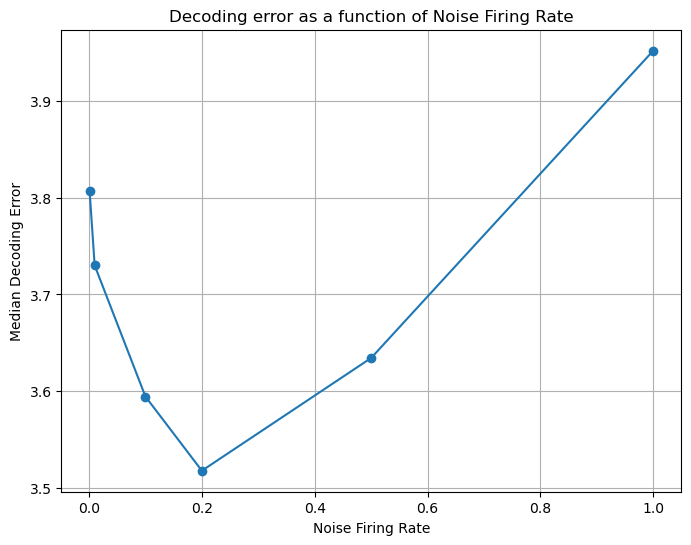

In [9]:
noise_firing_rate_list = [0.001, 0.01, 0.1, 0.2, 0.5, 1]
median_error_list = []

for noise_firing_rate in noise_firing_rate_list:
    data_name = f"linear_track_data_fr{noise_firing_rate}.pickle"
    median_error = decode(data_name)
    median_error_list.append(median_error)
    
plt.figure(figsize=(8, 6))
plt.plot(noise_firing_rate_list, median_error_list, 'o-')
plt.xlabel('Noise Firing Rate')
plt.ylabel('Median Decoding Error')
plt.title('Decoding error as a function of Noise Firing Rate')
plt.grid(True)
plt.show()

In the graph above we see an increase in the median error for both high and low values of the noise_firing_rate. The former seems counterintuitive. I don't have an explanation to why that is. I also can't find any obvious mistakes or clues in the code. However the higher decoding error for high noise seems to make sense for the obvious reasons: it is easier to decode the true value if the signal is less affected by random fluctuations.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




100%|█████████████████████████████████████████████████████████████████████████████| 5231/5231 [00:30<00:00, 168.98it/s]


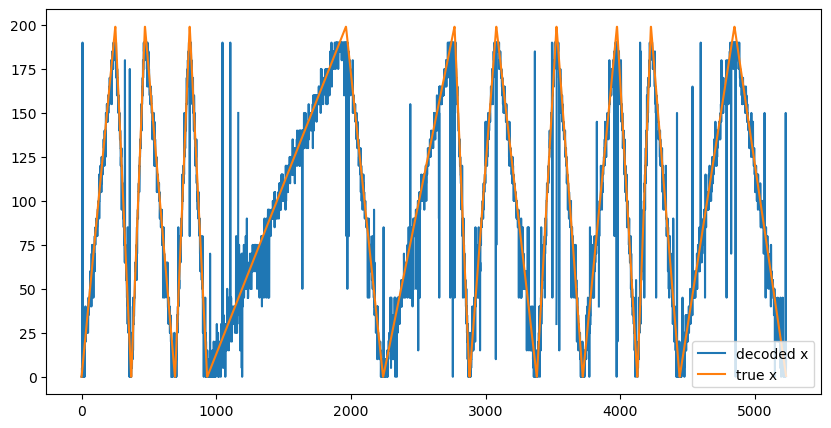

In [10]:
for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   

plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

100%|█████████████████████████████████████████████████████████████████████████████| 5231/5231 [00:40<00:00, 128.03it/s]


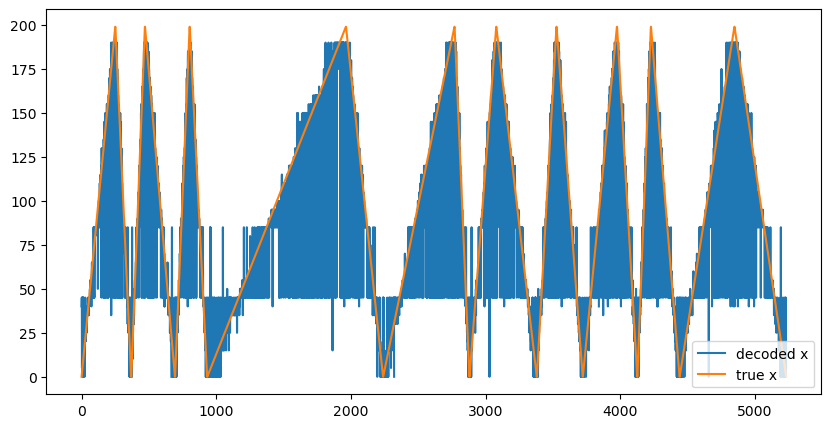

In [11]:
for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            #posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   

plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

We can see very noticable differences between the two plots. Whereas the decoded value of x is very accurate to the true value in the first plot, it varies a lot in the second plot. It is much less accurate. Since the two expressions are mathematically identical the difference should be due to how Python handles the two expressions. Considering we are working with logarithms of (possibly) very low values I suspect that the first expression (poisson.logpmf(k,mu) is numerically more stable. Whereas we see artifacts of tiny numerical shifts amplified by the logarithm.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### A

In [12]:
def get_p_values(noise_x_react=5, noise_t_react=5):
    # generate data 
    n_events = 200 # number of reactivation events
    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_firing_rate = 0.1 # the baseline noise firing rate

    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length
    
        #store reactivation sequence
        reactivation_events[event,:] = x_react
    
        # Generate spikes according to the location being reactivated in this event
    
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1
            
    # to do: bayesian decoding
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)

        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)), x_decoded)
            reactivation_pvalues[event] = corr[1]
    return reactivation_pvalues

In [15]:
# Calculating false positives and negatives
significance_level = 0.05
n_events = 200

reactivation_p_values = get_p_values()
false_positives = np.sum(reactivation_p_values[n_events//2:] < significance_level)
false_negatives = np.sum(reactivation_p_values[:n_events//2] < significance_level)

# Printing the found amounts
print(f"The amount of false positives is: {false_positives}")
print(f"The amount of false negatives is: {false_negatives}")

The amount of false positives is: 0
The amount of false negatives is: 9


We can estimate the quality of the sequence detection methods by calculating the false positives and negatives. These correspond to events with a p value below 0.05. For the first and last 100 events respectfully. Since we see a low amount of false flagged events we can conclude that the quality of this method is good.

### B

In [16]:
noise_react_list = [1, 2, 5, 10, 50, 100]

for noise_x_react in noise_react_list:
    reactivation_pvalues = get_p_values(noise_x_react)
    
    # Calculating false positives and negatives
    significance_level = 0.05
    n_events = 200
    
    false_positives = np.sum(reactivation_pvalues[n_events//2:] < significance_level)
    false_negatives = np.sum(reactivation_pvalues[:n_events//2] < significance_level)

    # Printing the found amounts
    print(f"The noise_x_react value is: {noise_x_react}")
    print(f"The amount of false positives is: {false_positives}")
    print(f"The amount of false negatives is: {false_negatives}")
    print("-" * 10)

The noise_x_react value is: 1
The amount of false positives is: 4
The amount of false negatives is: 6
----------
The noise_x_react value is: 2
The amount of false positives is: 1
The amount of false negatives is: 4
----------
The noise_x_react value is: 5
The amount of false positives is: 0
The amount of false negatives is: 12
----------
The noise_x_react value is: 10
The amount of false positives is: 2
The amount of false negatives is: 8
----------
The noise_x_react value is: 50
The amount of false positives is: 3
The amount of false negatives is: 4
----------
The noise_x_react value is: 100
The amount of false positives is: 2
The amount of false negatives is: 2
----------


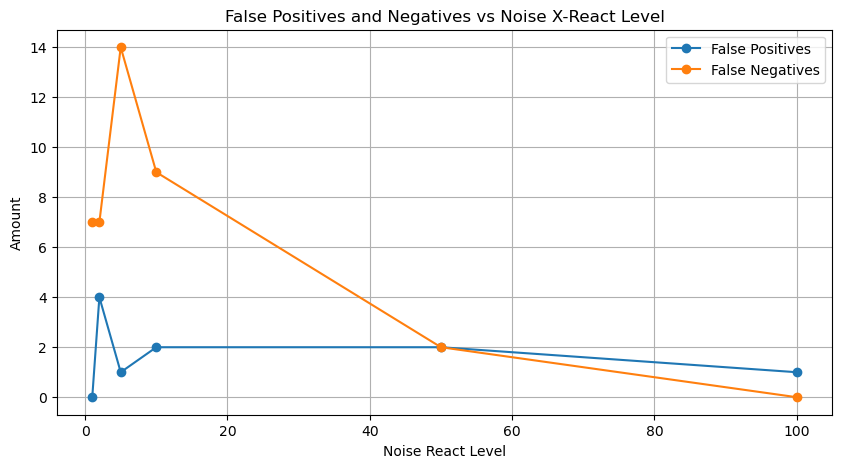

In [17]:
noise_react_list = [1, 2, 5, 10, 50, 100]

# Creating lists to keep track of false positives and negatives
fp_list = []
fn_list = []

for noise_x_react in noise_react_list:
    reactivation_pvalues = get_p_values(noise_x_react)
    
    # Calculating false positives and negatives
    significance_level = 0.05
    n_events = 200
    
    false_positives = np.sum(reactivation_pvalues[n_events//2:] < significance_level)
    false_negatives = np.sum(reactivation_pvalues[:n_events//2] < significance_level)
    
    # Adding amounts to the lists
    fp_list.append(false_positives)
    fn_list.append(false_negatives)

# Plotting the results
plt.figure(figsize=(10, 5))

plt.plot(noise_react_list, fp_list, label='False Positives', marker='o')
plt.plot(noise_react_list, fn_list, label='False Negatives', marker='o')

plt.xlabel('Noise React Level')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.title('False Positives and Negatives vs Noise X-React Level')
plt.show()


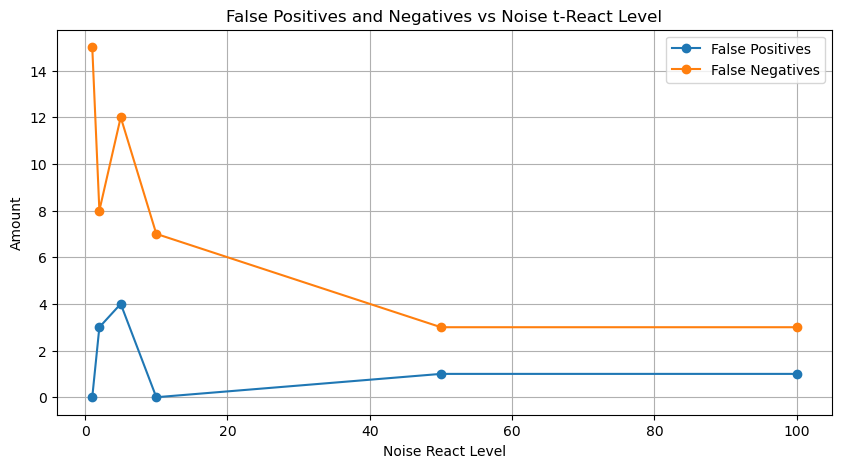

In [18]:
noise_react_list = [1, 2, 5, 10, 50, 100]

# Creating lists to keep track of false positives and negatives
fp_list = []
fn_list = []

for noise_t_react in noise_react_list:
    reactivation_pvalues = get_p_values(noise_x_react = 5, noise_t_react = noise_t_react)
    
    # Calculating false positives and negatives
    significance_level = 0.05
    n_events = 200
    
    false_positives = np.sum(reactivation_pvalues[n_events//2:] < significance_level)
    false_negatives = np.sum(reactivation_pvalues[:n_events//2] < significance_level)
    
    # Adding amounts to the lists
    fp_list.append(false_positives)
    fn_list.append(false_negatives)

# Plotting the results
plt.figure(figsize=(10, 5))

plt.plot(noise_react_list, fp_list, label='False Positives', marker='o')
plt.plot(noise_react_list, fn_list, label='False Negatives', marker='o')

plt.xlabel('Noise React Level')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.title('False Positives and Negatives vs Noise t-React Level')
plt.show()


We see quite interesting behaviour. When varying the both noise parameters we see that the false positives and false negatives are inverse related. When one of the two increases the other decreases and vice versa. Therefore a trade off must be made in the parameters. The optimal value, such that both false flags are equal in value, seems to be around 30 for both parameters.

In a second run (upon checking if my code ran properly) I see slightly different behaviour, where the amount of flags remain constant for both positives and negatives at high noise levels.

### C

Our method can detect linear sequences (in time), where the spatial positions are traversed in a smooth and orderd manner. Therefore it might fail to capture more complex structures. Which are, for instance, nonlinear or unsmooth. The former meaning the traverse speed has a large variance. Similarly if the speed is too fast, or the bins too broad, the position won't be encoded. 

Another possibility for a sequence detection model would be to use machine learning models such as recurrent neural networks. Though for such relatively straight forward data this might be overkill